In [1]:
import cv2
import os
import numpy as np
from scipy.cluster.vq import kmeans, vq
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

1.	Selecting representative images from an image dataset 

In [2]:
train_path = './Dataset/Train'
os.listdir(train_path)
labels = []
train_img_list = []
train_id_list = []
train_folder_path = os.listdir(train_path)

In [3]:
# Ambil train path untuk setiap gambar
for idx, folder_path in enumerate(train_folder_path):
    full_path = f'{train_path}/{folder_path}'
    labels.append(folder_path)
    # ./Dataset/Train/Aeroplane/1.jpg
    for image_path in os.listdir(full_path):
        train_id_list.append(idx)
        image_full_path = f'{train_path}/{folder_path}/{image_path}'
        train_img_list.append(image_full_path)

In [4]:
print("Classes:")
for index,label in enumerate(labels):
    print(f'{index+1}.{label}')

Classes:
1.Bean
2.Bitter_Gourd
3.Bottle_Gourd
4.Brinjal
5.Broccoli
6.Cabbage
7.Capsicum
8.Carrot
9.Cauliflower
10.Cucumber
11.Papaya
12.Potato
13.Pumpkin
14.Radish
15.Tomato


2.	Collect all the SIFT descriptors from the images in 1)

        SURF can no longer be used because of patent issue with OpenCV. Therefore SIFT method is used.

In [5]:
# membuat object SIFT
sift = cv2.SIFT_create()

# membuat list untuk menyimpan descriptor
train_descriptor_list = []

for img in train_img_list:
    image =     cv2.imread(img)
    _, train_descriptor = sift.detectAndCompute(image, None)
    train_descriptor_list.append(train_descriptor) # menambahkan descriptor dari ke list train descriptor


In [6]:
stacked_descriptor_list = train_descriptor_list[0]
for descriptor in train_descriptor_list[1:]:
    stacked_descriptor_list = np.vstack(
        (stacked_descriptor_list,descriptor)
    )

stacked_descriptor_list = np.float32(stacked_descriptor_list)

3.	Cluster these descriptors using K Means into k number of clusters where k is a number you set. The center of these clusters are the "visual words" i.e. representative features in your database of images.

In [7]:
# k means
centroids, _ = kmeans(stacked_descriptor_list, k_or_guess=3, iter=100) # yang diambil hanya centroidnya
length_image_list = len(train_img_list) # panjang dari train image list
length_centroids = len(centroids) # panjang dari centroids
train_features = np.zeros(
    (length_image_list, length_centroids), 
    dtype='float32'
    )

4.	For every image in the database, you are going to create a vector V that counts how frequently the different features in the dictionary occurs so each image would be represented by a vector in the form of: <# times feature 1 in dictionary occur, ... feature 2 in dictionary occur..., ..., ... feature k in dictionary occurs > i.e., a k dimensional vector. You obtain this vector for an image by:
- Extracting SURF descriptors in the image
- For each SURF descriptor in the image, find the closest cluster center (using Euclidean distance) in the codebook/dictionary and increment its corresponding count in the vector v by 1.

In [8]:
# vq (vector quantization)
for i in range(len(train_img_list)):
    words, _ = vq(train_descriptor_list[i], centroids)
    for word in words:
        train_features[i][word] += 1
# print(train_features)

5.	At this stage, you might want to normalize the histogram by dividing each entry by the sum of all the entries so that images with very different number of SIFT key-points found can be made comparable.

In [9]:
# membuat object standard scaler
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features) #fitting data train dengan standard scaler

In [10]:
# membuat object svc
svc = LinearSVC()
array_id = np.array(train_id_list)
svc.fit(train_features, array_id)

LinearSVC()

6.	Now, to compare 2 images, you compare this new vector V instead of the SIFT descriptors themselves. It is recommended to use cosine similarity to evaluate how close your query image with images in the database.

In [11]:
# test data
test_path = './Dataset/Test'
test_img_list = [f'{test_path}/{img}' for img in os.listdir(test_path)]
# print(test_img_list)

In [12]:
test_descriptor_list = [] #membuat list kosong untuk menampung descriptor
for image_path in test_img_list:
    image = cv2.imread(image_path) #membaca gambar pada list tersebut
    _, test_descriptor = sift.detectAndCompute(image, None)
    test_descriptor_list.append(test_descriptor)

length_test_img = len(test_img_list)
test_features = np.zeros(
    (length_test_img, length_centroids), 
    dtype='float32'
    )
for i in range(len(test_img_list)):
    words, _ = vq(test_descriptor_list[i], centroids)
    for word in words:
        test_features[i][word] += 1

test_feature = scaler.transform(test_features)
results = svc.predict(test_feature)
# print(results)

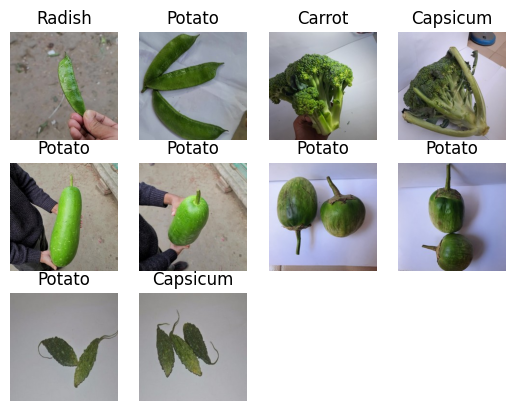

In [14]:
for idx, (id, image_path) in enumerate(zip(results, test_img_list)):
    plt.subplot(3,4,idx+1)
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.title(labels[id])
    plt.axis('off')
    # plt.xlabel([]),plt.ylabel([])

plt.show()